# Imports

In [1]:
%load_ext autoreload
import sys

sys.path.append('..')

In [2]:
%autoreload

import itertools, os, time, pickle, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from chexpert_approximator.data_processor import *
from chexpert_approximator.run_classifier import *

from chexpert_approximator.reload_and_get_logits import *

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
# We can't display MIMIC-CXR Output:

DO_BLIND = True
def blind_display(df):
    if DO_BLIND:     
        df = df.copy()
        index_levels = df.index.names
        df.reset_index('rad_id', inplace=True)
        df['rad_id'] = [0 for _ in df['rad_id']]
        df.set_index('rad_id', append=True, inplace=True)
        df = df.reorder_levels(index_levels, axis=0)

        for c in df.columns:
            if pd.api.types.is_string_dtype(df[c]): df[c] = ['SAMPLE' for _ in df[c]]
            else: df[c] = np.NaN

    display(df.head())

# Load the Data

In [4]:
DATA_DIR = '/scratch/chexpert_approximator/processed_data/' # INSERT YOUR DATA DIR HERE!
# DATA MUST BE STORED IN A FILE `inputs.hdf` under key `with_folds`.
INPUT_PATH, INPUT_KEY = os.path.join(DATA_DIR, 'inputs.hdf'), 'with_folds'

# YOUR CLINICAL BERT MODEL GOES HERE
BERT_MODEL_PATH = (
    '/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/'
)

# THIS IS WHERE YOUR PRE-TRAINED CHEXPERT++ MODEL LIVES
PRETRAINED_CXPPP_PATH = '/crimea/mmd/CheXpert_Approximator/out/run_1'

# DON'T MODIFY THESE
FOLD = 'Fold'

KEY = {
    0: 'No Mention',
    1: 'Uncertain Mention',
    2: 'Negative Mention',
    3: 'Positive Mention',
}
INV_KEY = {v: k for k, v in KEY.items()}
SENT_NUM = 'Sentence Number'

In [5]:
inputs = pd.read_hdf(INPUT_PATH, INPUT_KEY)
label_cols = [col for col in inputs.index.names if col not in ('rad_id', FOLD)]

In [6]:
sentence_num = pd.Series(index=inputs.index, data=1)
sentence_num = sentence_num.groupby('rad_id').cumsum()

inputs[SENT_NUM] = sentence_num
inputs.set_index(SENT_NUM, append=True, inplace=True)

In [7]:
print('Read %d sentences with %d labels: %s' % (len(inputs), len(label_cols), str(label_cols)))
blind_display(inputs.head())

Read 753611 sentences with 14 labels: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Airspace Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


sentence
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation Pneumonia  Atelectasis Pneumothorax Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number         
0      Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      6    1                 SAMPLE
                        Negative Mention           No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      6    2                 SAMPLE
                        No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      6    3                 SAMPLE
                                                                                                                                                                                                                    4    1                 SAMPLE
       No Mention       No Mention                 No Mention   No Mention  Positive Mention No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      4    2                 SAMPLE

# Baselines

In [8]:
keys = ['No Mention', 'Uncertain Mention', 'Positive Mention', 'Negative Mention']

frequencies = inputs[[]].reset_index()[label_cols].agg(lambda x: Counter(x))
frequencies = pd.DataFrame(
    index=frequencies.index, columns=keys, data=[[c[k] for k in keys] for c in frequencies]
)
frequencies /= len(inputs)

In [9]:
frequencies

,No Mention,Uncertain Mention,Positive Mention,Negative Mention
No Finding,0.335499,0.000000,0.664501,0.000000
Enlarged Cardiomediastinum,0.882995,0.023573,0.016118,0.077313
Cardiomegaly,0.905755,0.004673,0.051581,0.037990
Lung Lesion,0.990409,0.000920,0.007407,0.001265
Airspace Opacity,0.918940,0.004447,0.069406,0.007208
Edema,0.938679,0.010551,0.017238,0.033532
Consolidation,0.928832,0.005661,0.006956,0.058551
Pneumonia,0.966668,0.013388,0.008836,0.011108
Atelectasis,0.943740,0.007266,0.047652,0.001342
Pneumothorax,0.865748,0.002009,0.007625,0.124619


# Model
## Data Processor

In [10]:
class CheXpertProcessor(DataProcessor):
    def __init__(self, tuning_fold, held_out_fold):
        super().__init__()
        self.tuning_fold, self.held_out_fold = tuning_fold, held_out_fold
    
    """Processor for the CheXpert approximator.
    Honestly this is kind of silly, as it never stores internal state."""
    def get_train_examples(self, df): return self._create_examples(
        df, set([f for f in range(K) if f not in (self.tuning_fold, self.held_out_fold)])
    )
    def get_dev_examples(self, df):   return self._create_examples(df, set([self.tuning_fold]))
    def get_examples(self, df, folds=[]): return self._create_examples(df, set(folds))
    
    def get_labels(self): return {label: list(range(4)) for label in label_cols}

    def _create_examples(self, df, folds):
        """Creates examples for the training and dev sets."""
        df = df[df.index.get_level_values(FOLD).isin(folds)]
        lmap = {l: i for i, l in enumerate(df.index.names)}
        
        examples = []
        for idx, r in df.iterrows():
            labels = {l: INV_KEY[idx[lmap[l]]] for l in label_cols}
            
            examples.append(InputExample(
                guid=str(idx[lmap['rad_id']]), text_a=r.sentence, text_b=None, label=labels
            ))
        return examples

## Running the Model

In [11]:
processor = CheXpertProcessor(8, 9)
# train_examples = processor.get_train_examples(inputs)
# dev_examples = processor.get_dev_examples(inputs)

In [12]:
fold_8_sents = set(inputs[inputs.index.get_level_values(FOLD) == 8].sentence)
folds_0_7_sents = set()
for f in range(8):
    folds_0_7_sents.update(inputs[inputs.index.get_level_values(FOLD) == f].sentence)
restricted_fold_8_inputs = inputs[
    (inputs.index.get_level_values(FOLD) == 8) & ~inputs.sentence.isin(folds_0_7_sents)
]

In [14]:
len(inputs[inputs.index.get_level_values(FOLD) == 8])

75748

In [15]:
len(restricted_fold_8_inputs)

29166

In [20]:
start = time.time()
model, logits, results = reload_and_get_logits(
    restricted_fold_8_inputs,
    bert_model      = BERT_MODEL_PATH,
    processor       = processor,
    task_dimensions = {l: 4 for l in label_cols},
    output_dir      = PRETRAINED_CXPPP_PATH,
    gpu             = '0,1,2,3',
    seed            = 42,
    do_lower_case   = False,
    max_seq_length  = 128,
    batch_size      = 256,
    processor_args  = {'folds': [8]},
)
end = time.time()

print(results, end - start)

/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/
Max Sequence Length: 95



{'eval_loss': 0.1032366114750243, 'eval_accuracy': 0.9981117935756904} 214.65615105628967


In [27]:
chexpertPP_time = (end - start) / (60**2) * 10 # in hours

print("Total time was %.2fh" % chexpertPP_time)

Total time was 0.60h


In [28]:
logits_dfs = {k: pd.DataFrame(
    np.vstack(v), columns=[KEY[i] for i in range(4)],
    index=restricted_fold_8_inputs.index
) for k, v in logits.items()}

for k, df in logits_dfs.items():
    df.columns = pd.MultiIndex.from_tuples([(k, c) for c in df.columns], names=('Task', 'Label'))
logits_df = pd.concat(logits_dfs.values(), axis=1)

In [29]:
print("Produced %d %d-dim Logits in %.2f min." % (logits_df.shape[0], logits_df.shape[1], 60*chexpertPP_time/10))
blind_display(logits_df.head())

Produced 29166 56-dim Logits in 3.58 min.


Task                                                                                                                                                                                                                                          No Finding  \
Label                                                                                                                                                                                                                                         No Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation Pneumonia  Atelectasis Pneumothorax     Pleural Effusion Pleural Other Fracture   Support Devices  Fold Sentence Number              
0      Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention Positive Mention 8    2                      NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention       No Mention    No Mention No Mention       8    3                      NaN   
                                                                                                                                                                                                                              4                      NaN   
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention       8    5                      NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention       No Mention    No Mention No Mention       8    6                      NaN   

Task                                                                                                                                                                                                                                                             \
Label                                                                                                                                                                                                                                         Uncertain Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation Pneumonia  Atelectasis Pneumothorax     Pleural Effusion Pleural Other Fracture   Support Devices  Fold Sentence Number                     
0      Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention Positive Mention 8    2                             NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention       No Mention    No Mention No Mention       8    3                             NaN   
                                                                                                                                                                                                                              4                             NaN   
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention       8    5                             NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention  

## More detailed Results

In [30]:
confusion_matrices = {}
keys = [KEY[i] for i in range(4)]
error_rates = {'Majority Class': [], 'chexpertPP': []}
confusion_subarrays = []
confusion_flattened_subarrays = []
normalized_confusion_flattened_subarrays = []

for i, task in enumerate(label_cols):
    logits = logits_df[task]
    labels = logits_df.index.get_level_values(task)
    predictions = logits.idxmax(axis=1)
    c = confusion_matrix(list(labels.values), list(predictions.values), labels=keys)
    c = pd.DataFrame(c, index=['True %s' % l for l in keys], columns=['Predicted %s' % l for l in keys])
    
    overall_accuracy = c.values[np.diag_indices(4)].sum() / len(logits_df) * 100
    mc_accuracy = frequencies.max(axis=1)[task] * 100
    
    error_rates['Majority Class'].append((100 - mc_accuracy))
    error_rates['chexpertPP'].append((100 - overall_accuracy))
    confusion_subarrays.append(
        [np.NaN * np.ones((4, 4))] * i + [c.values] + [np.NaN * np.ones((4, 4))] * (len(label_cols) - i - 1)
    )
    confusion_flattened_subarrays.append(c.values)
    normalized_confusion_flattened_subarrays.append(c.values / c.values.sum(axis=1, keepdims=True))
    
    print(
        "For %s, we obtain Accuracy %.2f%% (vs. majority class %.2f%%). Error rates %.2e %% vs. %.2e %%."
        "" % (task, overall_accuracy, mc_accuracy, 100 - overall_accuracy, 100 - mc_accuracy)
    )
    display(c)
    confusion_matrices[task] = c
    
error_rates = pd.DataFrame(error_rates, index=label_cols)
global_confusion_matrix = np.block(confusion_subarrays)
confusion_matrix_flattened = np.block(confusion_flattened_subarrays)
normalized_confusion_matrix_flattened = np.block(normalized_confusion_flattened_subarrays)

For No Finding, we obtain Accuracy 99.42% (vs. majority class 66.45%). Error rates 5.83e-01 % vs. 3.35e+01 %.


/scratch/conda_envs/chexpert_approximator/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,16813,0,0,90
True Uncertain Mention,0,0,0,0
True Negative Mention,0,0,0,0
True Positive Mention,80,0,0,12183


For Enlarged Cardiomediastinum, we obtain Accuracy 99.80% (vs. majority class 88.30%). Error rates 2.02e-01 % vs. 1.17e+01 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,27646,0,0,0
True Uncertain Mention,0,404,1,12
True Negative Mention,0,2,397,7
True Positive Mention,0,22,15,660


For Cardiomegaly, we obtain Accuracy 99.79% (vs. majority class 90.58%). Error rates 2.13e-01 % vs. 9.42e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,27148,0,0,2
True Uncertain Mention,1,150,3,15
True Negative Mention,0,2,261,16
True Positive Mention,0,8,15,1545


For Lung Lesion, we obtain Accuracy 99.97% (vs. majority class 99.04%). Error rates 3.09e-02 % vs. 9.59e-01 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,28453,0,0,0
True Uncertain Mention,0,76,0,2
True Negative Mention,1,0,70,1
True Positive Mention,0,5,0,558


For Airspace Opacity, we obtain Accuracy 99.81% (vs. majority class 91.89%). Error rates 1.89e-01 % vs. 8.11e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,23614,0,0,0
True Uncertain Mention,0,221,0,21
True Negative Mention,0,1,279,12
True Positive Mention,0,16,5,4997


For Edema, we obtain Accuracy 99.87% (vs. majority class 93.87%). Error rates 1.30e-01 % vs. 6.13e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,26905,0,0,1
True Uncertain Mention,0,556,4,9
True Negative Mention,0,6,632,1
True Positive Mention,0,8,9,1035


For Consolidation, we obtain Accuracy 99.81% (vs. majority class 92.88%). Error rates 1.85e-01 % vs. 7.12e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,27742,0,0,1
True Uncertain Mention,0,223,3,10
True Negative Mention,0,1,681,6
True Positive Mention,0,27,6,466


For Pneumonia, we obtain Accuracy 99.77% (vs. majority class 96.67%). Error rates 2.30e-01 % vs. 3.33e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,27479,0,0,0
True Uncertain Mention,0,738,3,11
True Negative Mention,0,2,366,3
True Positive Mention,0,37,11,516


For Atelectasis, we obtain Accuracy 99.74% (vs. majority class 94.37%). Error rates 2.64e-01 % vs. 5.63e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,25665,0,0,0
True Uncertain Mention,0,500,0,19
True Negative Mention,0,1,64,13
True Positive Mention,0,36,8,2860


For Pneumothorax, we obtain Accuracy 99.86% (vs. majority class 86.57%). Error rates 1.41e-01 % vs. 1.34e+01 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,27800,0,1,1
True Uncertain Mention,0,77,14,1
True Negative Mention,0,3,818,6
True Positive Mention,0,2,13,430


For Pleural Effusion, we obtain Accuracy 99.75% (vs. majority class 83.81%). Error rates 2.47e-01 % vs. 1.62e+01 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,25197,0,0,0
True Uncertain Mention,0,308,12,10
True Negative Mention,0,8,838,6
True Positive Mention,0,27,9,2751


For Pleural Other, we obtain Accuracy 99.97% (vs. majority class 99.56%). Error rates 2.74e-02 % vs. 4.40e-01 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,28865,0,0,1
True Uncertain Mention,0,54,1,3
True Negative Mention,0,0,11,1
True Positive Mention,0,2,0,228


For Fracture, we obtain Accuracy 99.95% (vs. majority class 98.69%). Error rates 4.80e-02 % vs. 1.31e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,28537,0,0,0
True Uncertain Mention,0,25,2,1
True Negative Mention,0,0,78,2
True Positive Mention,0,7,2,512


For Support Devices, we obtain Accuracy 99.85% (vs. majority class 91.02%). Error rates 1.54e-01 % vs. 8.98e+00 %.


,Predicted No Mention,Predicted Uncertain Mention,Predicted Negative Mention,Predicted Positive Mention
True No Mention,23988,0,0,2
True Uncertain Mention,0,27,0,9
True Negative Mention,0,0,270,10
True Positive Mention,3,10,11,4836


In [33]:
display(error_rates)
# print(error_rates.round(2).to_latex())

,Majority Class,chexpertPP
No Finding,33.549935,0.582870
Enlarged Cardiomediastinum,11.700466,0.202290
Cardiomegaly,9.424491,0.212576
Lung Lesion,0.959116,0.030858
Airspace Opacity,8.106039,0.188576
Edema,6.132076,0.130289
Consolidation,7.116802,0.185147
Pneumonia,3.333152,0.229720
Atelectasis,5.625979,0.264006
Pneumothorax,13.425229,0.140575


/scratch/conda_envs/chexpert_approximator/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


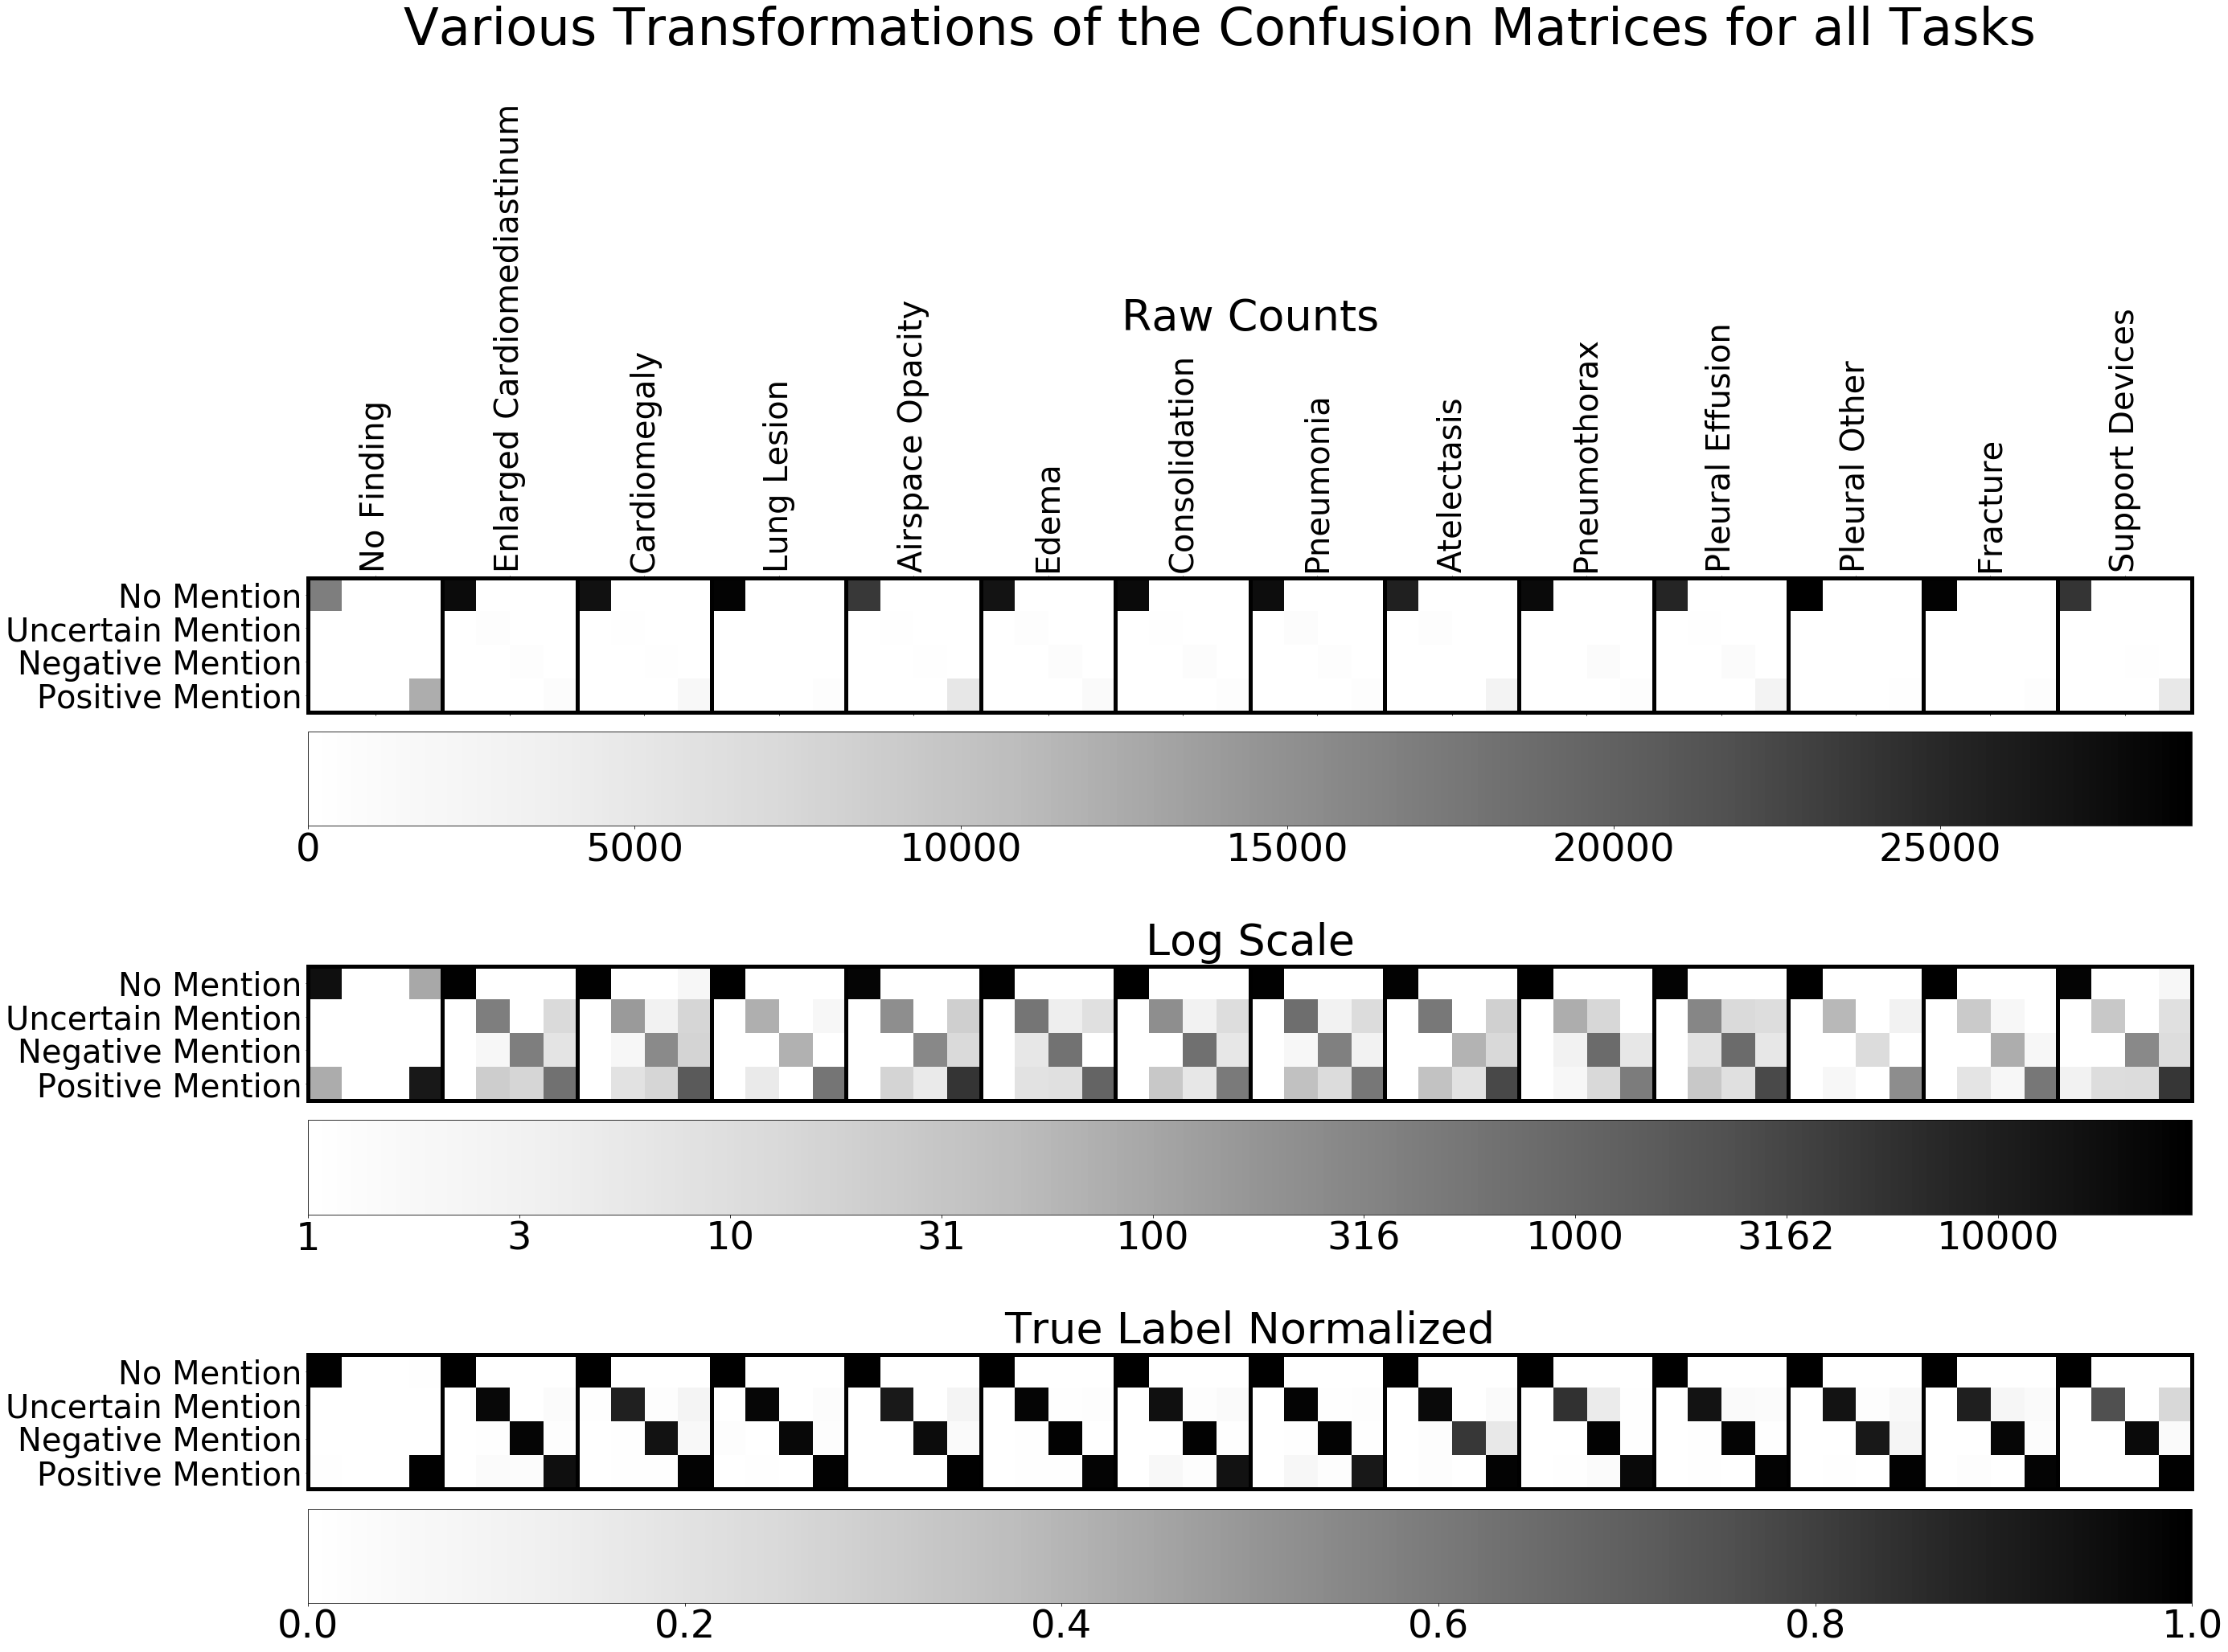

In [34]:
fig, (ax_raw, ax_log, ax_norm) = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(42, 40))
fig.suptitle('Various Transformations of the Confusion Matrices for all Tasks', fontsize=64, y=0.9)

logbase = 10

for row, (ax, mat, title) in enumerate((
    (ax_raw, confusion_matrix_flattened, 'Raw Counts'),
    (ax_norm, normalized_confusion_matrix_flattened, 'True Label Normalized'),
    (ax_log, np.log10(confusion_matrix_flattened), 'Log Scale'),
)):
    m_handle = ax.matshow(mat, cmap='Greys')
    ax.set_yticks([i for i in range(len(keys))])
    ax.set_yticklabels(keys, fontsize=40)
    
    if row == 0: ax.set_title(title, fontsize=54, pad=300)
    else:
        ax.set_title(title, fontsize=54)
        ax.set_xticks([])
        ax.set_xticklabels([])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(5)

    # ax.grid(True, which='minor', axis='x')

    for i, label in enumerate(label_cols):
        ax.axvline(4*(i+1) - 0.5, 0, 1, linewidth=5, color='k')

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(mappable=m_handle, ax=ax, fraction=0.3, pad=0.02, orientation='horizontal')
    cbar.ax.tick_params(labelsize=48)
    if title.startswith('Log'):
        old_ticks = [x for x in cbar.get_ticks()]
        new_ticks = [int(logbase**x) for x in old_ticks]
        cbar.set_ticks(old_ticks)
#         cbar.set_ticklabels(['$e^{%d} ≈ %d$' % v for v in zip(old_ticks, new_ticks)])
        cbar.set_ticklabels(new_ticks)
    

ax_raw.set_xticks([1.5 + 4*i for i in range(len(label_cols))])
ax_raw.set_xticklabels(label_cols, fontsize=40, rotation=90)
plt.subplots_adjust(hspace=-0.6)

plt.show()

## Manual Check of misclassifications

In [35]:
with_inputs = logits_df.copy()
with_inputs['Sentence'] = restricted_fold_8_inputs.sentence

In [36]:
blind_display(with_inputs.head())

Task                                                                                                                                                                                                                                          No Finding  \
Label                                                                                                                                                                                                                                         No Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation Pneumonia  Atelectasis Pneumothorax     Pleural Effusion Pleural Other Fracture   Support Devices  Fold Sentence Number              
0      Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention Positive Mention 8    2                      NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention       No Mention    No Mention No Mention       8    3                      NaN   
                                                                                                                                                                                                                              4                      NaN   
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention       8    5                      NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention       No Mention    No Mention No Mention       8    6                      NaN   

Task                                                                                                                                                                                                                                                             \
Label                                                                                                                                                                                                                                         Uncertain Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation Pneumonia  Atelectasis Pneumothorax     Pleural Effusion Pleural Other Fracture   Support Devices  Fold Sentence Number                     
0      Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention Positive Mention 8    2                             NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention       No Mention    No Mention No Mention       8    3                             NaN   
                                                                                                                                                                                                                              4                             NaN   
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention       8    5                             NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  Positive Mention No Mention  

In [37]:
os.makedirs('./misclassifications/')

In [39]:
all_misclassified_sentences = []

sentences = with_inputs['Sentence']
for task in label_cols:
    labels = with_inputs.index.get_level_values(task)
    predictions = with_inputs[task].idxmax(axis=1)
    misclassified_samples = with_inputs[labels != predictions]
    tuples = np.random.permutation(
        list(zip(*(d[labels != predictions].values for d in (labels, predictions, sentences))))
    )
    
    misclassifications_df = pd.DataFrame(tuples, columns=['Labeler A', 'Labeler B', 'Sentence'])
    misclassifications_df.to_csv(os.path.join('./misclassifications', '%s.csv' % task))
    
    all_misclassified_sentences.extend(misclassifications_df.Sentence)